# Imports 
Necessary imports, based in part on [this](https://www.kaggle.com/code/awsaf49/planttraits2024-kerascv-starter-notebook)

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

# deep learning
import keras_cv
import keras
from keras import ops
import tensorflow as tf
import cv2
import umap.umap_ as umap

# data processing
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import sklearn
from sklearn.decomposition import PCA

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import model

nn = model.Model("model1")

print(nn.name) # model1

# Data pre-processing

## Loading
The general format of each instance of the data is 
```
[ids*, ancillary data*, trait means*, traits sd*, image path]
```

In [ ]:
from config import config
DATA_PATH = "../data"

# creating df that has image path and related ancillary data
df = pd.read_csv(DATA_PATH + "/train.csv")
df['image_path'] = f'{DATA_PATH}/train_images/' + str(df['id']) + '.jpeg'
df.loc[:, config.aux_class_names] = df.loc[:, config.aux_class_names].fillna(-1)
display(df.head(2))
print(df.shape[0]) 

# same df but for the test data
test_df = pd.read_csv(DATA_PATH + "/test.csv")
df['image_path'] = f'{DATA_PATH}/test_images'+ str(test_df['id']) + '.jpeg'
FEATURE_COLS = list(test_df.columns[1:-1])
display(test_df.head(2))
print(test_df.shape[0])

## traits

### mean traits

In [ ]:
mean_traits = df.iloc[:, 164:170]
sd_traits = df.iloc[:, 170:176]
display(mean_traits.head(2))


def mean_normalizer(col):
    mean = mean_traits.iloc[:, col]
    mean = mean.drop_duplicates()
    return (mean - mean.min()) / (mean.max() - mean.min())

plt.figure(figsize=(10, 5))
for i in range(6): 
    plt.hist(mean_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized x{i} mean')
    
plt.title('Normalized mean trait distributions')
plt.xlabel('Normalized mean trait value')
plt.ylabel('Log count')
plt.legend()
plt.show()

In [ ]:
x_11_mean = mean_traits.iloc[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# remove outliers
x_11_mean = x_11_mean[x_11_mean.between(x_11_mean.quantile(0), x_11_mean.quantile(1))]

x_11_mean = x_11_mean.drop_duplicates()

ax[0].hist(x_11_mean, bins=100, log=True, alpha=0.5)
ax[0].set_title('x11 mean distribution')
ax[0].set_xlabel('x11 mean value')
ax[0].set_ylabel('Log count')

x_11_mean = x_11_mean[x_11_mean.between(x_11_mean.quantile(0), x_11_mean.quantile(0.99))]
print(x_11_mean.count())
ax[1].hist(x_11_mean, bins=100, alpha=0.5)
ax[1].set_title('x11 mean distribution (99th percentile)')
ax[1].set_xlabel('x11 mean value')
ax[1].set_ylabel('Instance count')

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(30, 5))

for i in range(6):
    x_mean = mean_traits.iloc[:, i]
    x_mean = x_mean[x_mean.between(x_mean.quantile(0), x_mean.quantile(0.99))]
    x_mean = x_mean.drop_duplicates()
    
    ax[i].hist(x_mean, bins=100, log=True, alpha=0.5, label=f'Normalized x{i} mean')
    ax[i].set_title(f'x{i} mean distribution (99th percentile)')
    ax[i].set_xlabel(f'x{i} mean value')
    ax[i].set_ylabel('Log count')

This gives us some idea of the distribution of the targets we are training for. One thing to consider is that this distribution of traits might not be representative of the general traits of plant species. 
*Notes*
- we can maybe check some location data to see where most of the images came from to see if certain traits indicate a geographic bias 

### sd traits

In [ ]:
sd_traits = df.iloc[:, 170:176]
display(sd_traits.head(2))
def sd_normalizer(col):
    sd = sd_traits.iloc[:, col]
    return (sd - sd.min()) / (sd.max() - sd.min())

plt.figure(figsize=(10, 5))
for i in range(6):  
    plt.hist(sd_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized SD x{i}')

plt.title('Normalized standard deviation trait distributions')
plt.legend()
plt.show()


This might be an even better representative that we are training towards a biased sample. Intuitively I'd assume that traits would probably have a large variance if we have a geographic diversity in our sample, but here it seems this is less so the case for most of the deviations maybe ?

## ancillary data

In [ ]:
ancillary_data = df.iloc[:, 1:164]

fig = plt.figure(figsize=(10, 10))

# worldclim 
worldclim = ancillary_data.filter(like='WORLDCLIM')

g = sns.pairplot(worldclim, diag_kind='kde', plot_kws={'alpha': 0.5})

# remove labels 
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

[('WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range')]
PCA Reconstruction Loss: 0.0013435380898575225
UMAP Reconstruction Loss: 0.002739428402384099


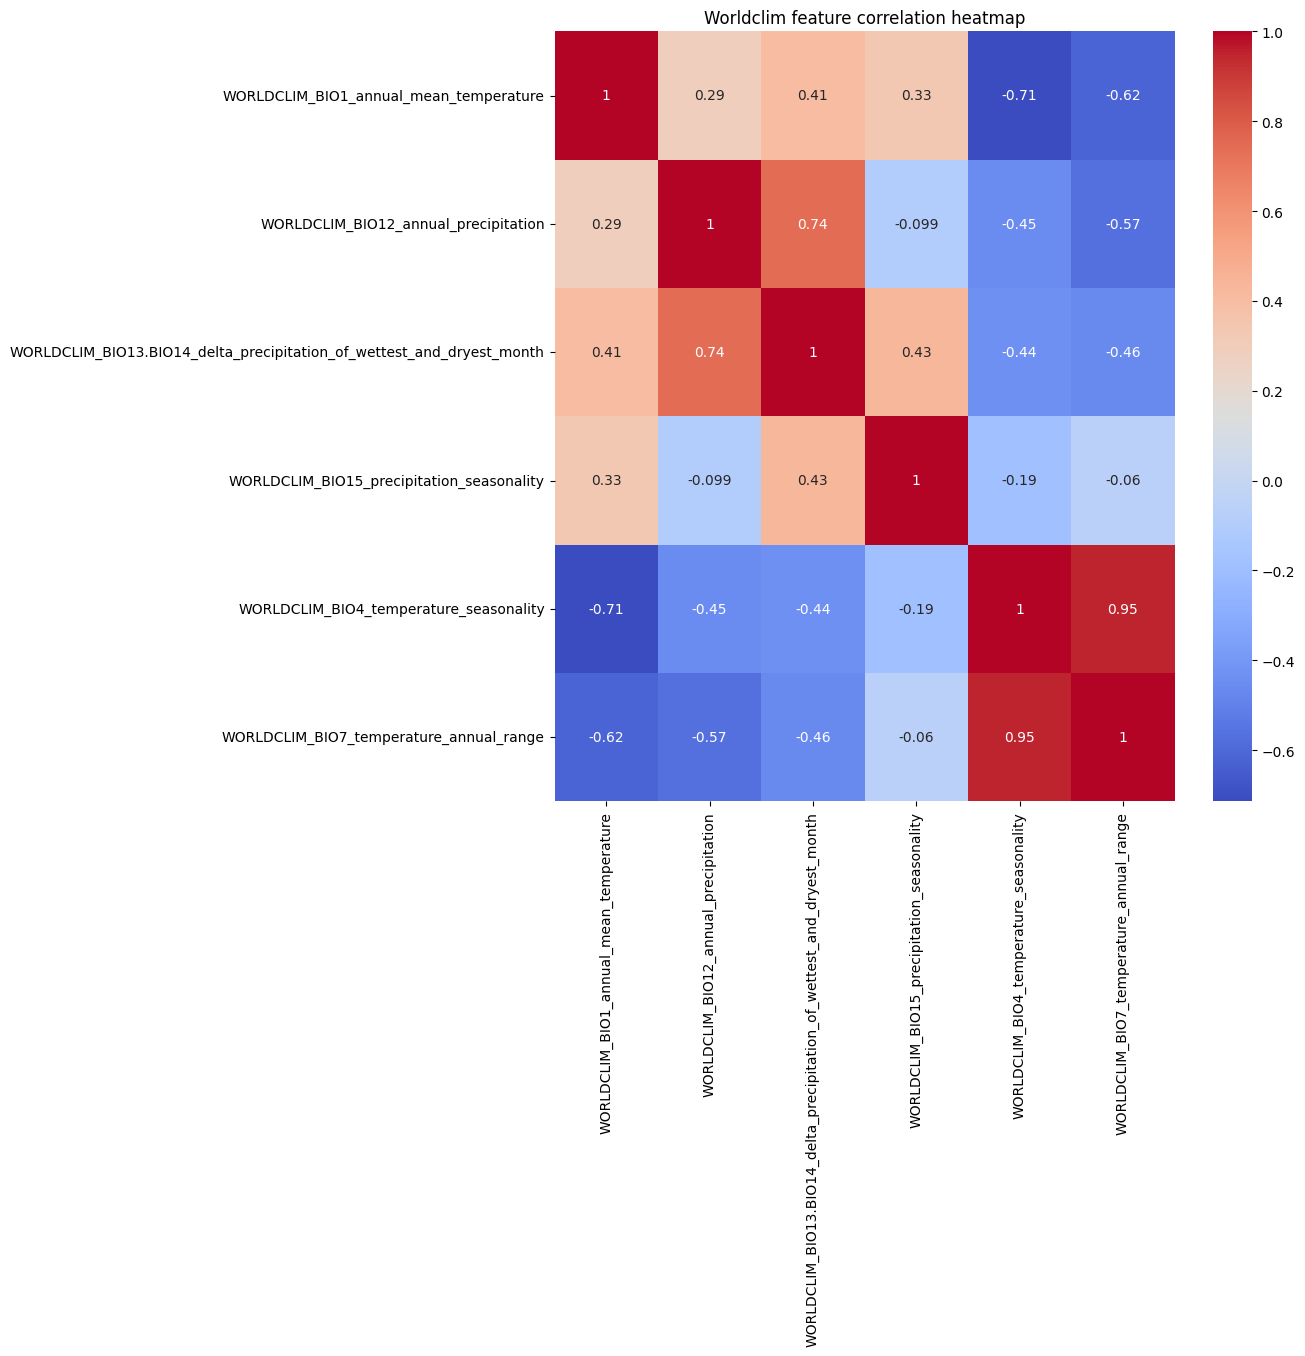

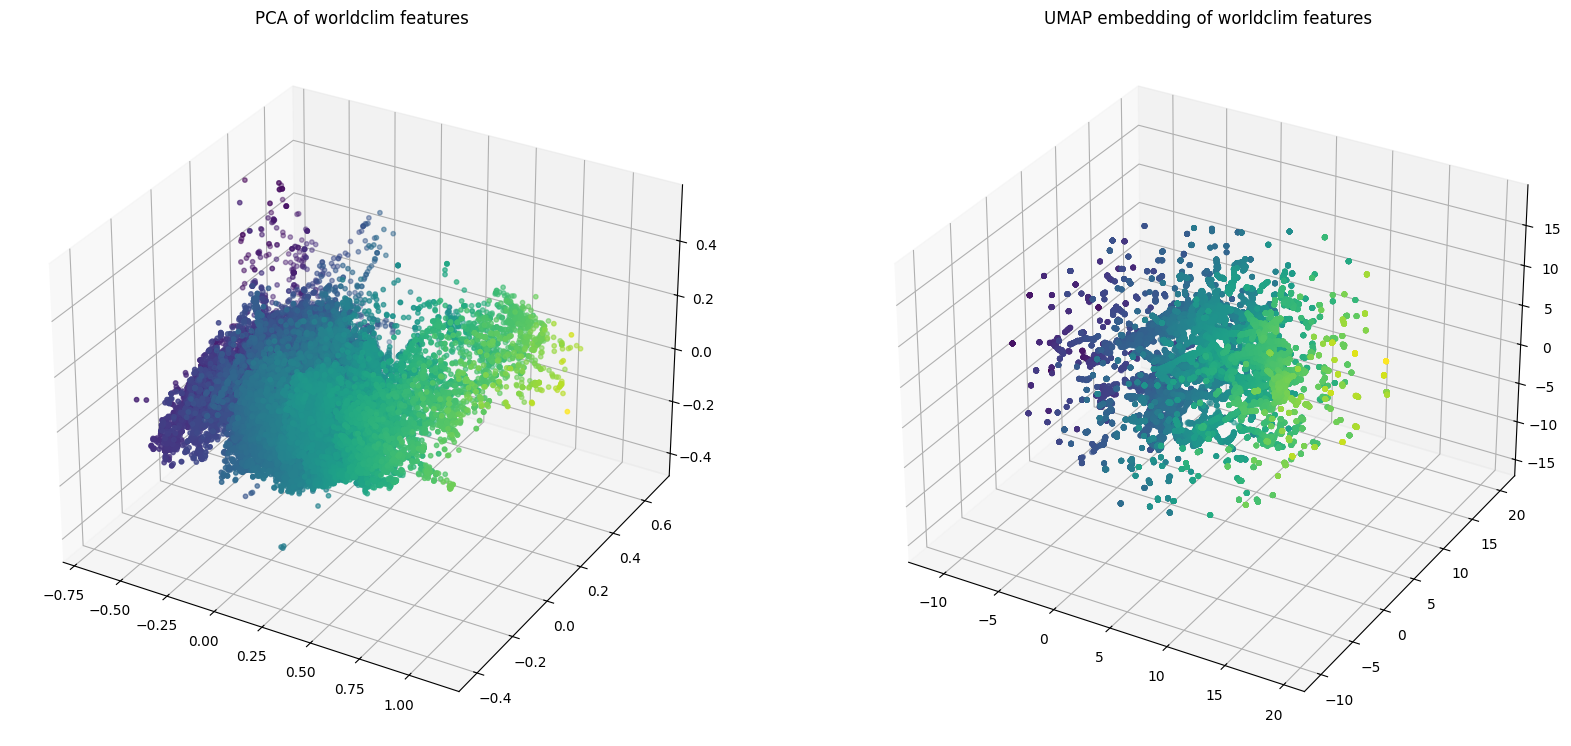

In [67]:
worldclim = ancillary_data.filter(like='WORLDCLIM')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
corr = worldclim.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)
ax.set_title('Worldclim feature correlation heatmap')

high_corr = [i for i in corr[corr > 0.9].stack().index.tolist() if i[0] != i[1]]
high_corr = list(set([tuple(sorted(i)) for i in high_corr]))

scaled_worldclim_data = (worldclim - worldclim.min()) / (worldclim.max() - worldclim.min())
print(high_corr)

# PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_worldclim_data)

fig = plt.figure(figsize=(20, 10))

# Plot PCA
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=pca_result[:, 0], cmap='viridis', s=10)
ax1.set_title('PCA of worldclim features')

reconstructed_pca = pca.inverse_transform(pca_result)
loss_pca = np.mean((scaled_worldclim_data - reconstructed_pca) ** 2)

print(f'PCA Reconstruction Loss: {loss_pca}')

# UMAP
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(scaled_worldclim_data)

# Plot UMAP
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=embedding[:, 0], cmap='viridis', s=10)
ax2.set_title('UMAP embedding of worldclim features')

reconstructed_umap = reducer.inverse_transform(embedding)
loss_umap = np.mean((scaled_worldclim_data - reconstructed_umap) ** 2)

print(f'UMAP Reconstruction Loss: {loss_umap}')

plt.show()

So we start of by just looking at worldclim subset of our training data and testing out some of the basic methods we are going to then use on the broader dataset, namely finding correlations and then comparing the performance of PCA vs UAMP in the dimensionality reduction.

In [ ]:
ancillary_data = df.iloc[:, 1:164]
 
# select allcolumns with a name containing WORLDCLIM
worldclim   = ancillary_data.filter(like='WORLDCLIM')
soil        = ancillary_data.filter(like='SOIL')
modis       = ancillary_data.filter(like='MODIS')
vod         = ancillary_data.filter(like='VOD')

print(
    f"lengths {len(worldclim.columns)}, {len(soil.columns)}, {len(modis.columns)}, {len(vod.columns)}"
)
    

In [ ]:
# 3 x 1 subplot of correlation heatmaps 

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# soil 

soil_corr = soil.corr()
sns.heatmap(soil_corr, ax=ax[0], cmap='coolwarm', annot=False)

ax[0].set_title('Soil feature correlation heatmap')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

# modis

modis_corr = modis.corr()
sns.heatmap(modis_corr, ax=ax[1], cmap='coolwarm', annot=False)

ax[1].set_title('MODIS feature correlation heatmap')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# vod

vod_corr = vod.corr()
sns.heatmap(vod_corr, ax=ax[2], cmap='coolwarm', annot=False)

ax[2].set_title('VOD feature correlation heatmap')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

fig.tight_layout()
plt.show()

In [ ]:
correlations = [worldclim.corr(), soil.corr(), modis.corr(), vod.corr()]

high_corr = [] 

for corr in correlations:
    high_corr += [
        i for i in corr[corr > 0.9].stack().index.tolist() if i[0] != i[1]
    ]
    
mod_corr = []

for corr in correlations:
    mod_corr += [
        i for i in corr[corr > 0.65].stack().index.tolist() if i[0] != i[1]
    ]
    
total_cols = 164 
all_comb_num = total_cols * (total_cols - 1) / 2
    
high_corr = list(set([tuple(sorted(i)) for i in high_corr]))
print(
    f'num combinations with high correlation: {len(high_corr)}' + 
    f' ({len(high_corr) / all_comb_num * 100:.2f}%) ' 
)
print(
    f'num combinations with moderate correlation: {len(mod_corr)}' +
    f' ({len(mod_corr) / all_comb_num * 100:.2f}%)'
)

## missing data

In [ ]:
# iter over all rows in df and look for missing data

bad_rows = []
class_names = [n for n in config.aux_class_names if n.startswith("X") and n.endswith("_sd")]  # there is some missing data in the X*_sd columns
for i, row in df.iterrows():
    # check if any of those is a 0, -1 or 1
    if row[class_names].isin([0, -1, 1]).any():
        bad_rows.append(i)

# remove duplicates
bad_rows = set(bad_rows)
percentage_bad = len(bad_rows) / len(df) * 100
print(f"Found {len(bad_rows)} bad rows ({len(bad_rows)}/{len(df)}) ({percentage_bad:.2f}%)")

# display top 5 bad rows
df.iloc[list(bad_rows)].tail(5)

### where ?

Features marked as `X*_sd` are missing for almost 30% of the data (16387/55489) (29.53%). The rest of the data seems to be complete, with no other missing/zeroed values. We can ignore these rows, or we can simply ignore those features as it is a significant amount of data.

## data augmentation

## data split